In [1]:
!pip uninstall -qqy jupyterlab  # Remove unused conflicting packages
!pip install -U -q "google-genai==1.7.0"
from google import genai
from google.genai import types

genai.__version__

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 144.7/144.7 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.9/100.9 kB 5.6 MB/s eta 0:00:00


'1.7.0'

In [3]:
from kaggle_secrets import UserSecretsClient

GOOGLE_API_KEY = UserSecretsClient().get_secret("GOOGLE_API_KEY")

In [6]:
# Define a retry policy. The model might make multiple consecutive calls automatically
# for a complex query, this ensures the client retries if it hits quota limits.
from google.api_core import retry

is_retriable = lambda e: (isinstance(e, genai.errors.APIError) and e.code in {429, 503})

if not hasattr(genai.models.Models.generate_content, '__wrapped__'):
  genai.models.Models.generate_content = retry.Retry(
      predicate=is_retriable)(genai.models.Models.generate_content)

In [8]:
%load_ext sql
%sql sqlite:///sample.db

The sql extension is already loaded. To reload it, use:
  %reload_ext sql


In [9]:
%%sql
-- Create the 'products' table
CREATE TABLE IF NOT EXISTS products (
  	product_id INTEGER PRIMARY KEY AUTOINCREMENT,
  	product_name VARCHAR(255) NOT NULL,
  	price DECIMAL(10, 2) NOT NULL
  );

-- Create the 'staff' table
CREATE TABLE IF NOT EXISTS staff (
  	staff_id INTEGER PRIMARY KEY AUTOINCREMENT,
  	first_name VARCHAR(255) NOT NULL,
  	last_name VARCHAR(255) NOT NULL
  );

-- Create the 'orders' table
CREATE TABLE IF NOT EXISTS orders (
  	order_id INTEGER PRIMARY KEY AUTOINCREMENT,
  	customer_name VARCHAR(255) NOT NULL,
  	staff_id INTEGER NOT NULL,
  	product_id INTEGER NOT NULL,
  	FOREIGN KEY (staff_id) REFERENCES staff (staff_id),
  	FOREIGN KEY (product_id) REFERENCES products (product_id)
  );

-- Insert data into the 'products' table
INSERT INTO products (product_name, price) VALUES
  	('Laptop', 799.99),
  	('Keyboard', 129.99),
  	('Mouse', 29.99);

-- Insert data into the 'staff' table
INSERT INTO staff (first_name, last_name) VALUES
  	('Alice', 'Smith'),
  	('Bob', 'Johnson'),
  	('Charlie', 'Williams');

-- Insert data into the 'orders' table
INSERT INTO orders (customer_name, staff_id, product_id) VALUES
  	('David Lee', 1, 1),
  	('Emily Chen', 2, 2),
  	('Frank Brown', 1, 3);

 * sqlite:///sample.db
Done.
Done.
Done.
3 rows affected.
3 rows affected.
3 rows affected.


[]

In [11]:
import sqlite3

db_file = "sample.db"
db_conn = sqlite3.connect(db_file)

In [12]:
def list_tables() -> list[str]:
    """Retrieve the names of all tables in the database."""
    # Include print logging statements so you can see when functions are being called.
    print(' - DB CALL: list_tables()')

    cursor = db_conn.cursor()

    # Fetch the table names.
    cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")

    tables = cursor.fetchall()
    return [t[0] for t in tables]


list_tables()

 - DB CALL: list_tables()


['products', 'sqlite_sequence', 'staff', 'orders']

In [13]:
def describe_table(table_name: str) -> list[tuple[str, str]]:
    """Look up the table schema.

    Returns:
      List of columns, where each entry is a tuple of (column, type).
    """
    print(f' - DB CALL: describe_table({table_name})')

    cursor = db_conn.cursor()

    cursor.execute(f"PRAGMA table_info({table_name});")

    schema = cursor.fetchall()
    # [column index, column name, column type, ...]
    return [(col[1], col[2]) for col in schema]


describe_table("products")

 - DB CALL: describe_table(products)


[('product_id', 'INTEGER'),
 ('product_name', 'VARCHAR(255)'),
 ('price', 'DECIMAL(10, 2)')]

In [14]:
def execute_query(sql: str) -> list[list[str]]:
    """Execute an SQL statement, returning the results."""
    print(f' - DB CALL: execute_query({sql})')
    cursor = db_conn.cursor()
    cursor.execute(sql)
    return cursor.fetchall()
execute_query("select * from products")

 - DB CALL: execute_query(select * from products)


[(1, 'Laptop', 799.99), (2, 'Keyboard', 129.99), (3, 'Mouse', 29.99)]

In [15]:
db_tools = [list_tables, describe_table, execute_query]

instruction = """You are a helpful chatbot that can interact with an SQL database
for a computer store. You will take the users questions and turn them into SQL
queries using the tools available. Once you have the information you need, you will
answer the user's question using the data returned.

Use list_tables to see what tables are present, describe_table to understand the
schema, and execute_query to issue an SQL SELECT query."""

client = genai.Client(api_key=GOOGLE_API_KEY)

# Start a chat with automatic function calling enabled.
chat = client.chats.create(
    model="gemini-2.0-flash",
    config=types.GenerateContentConfig(
        system_instruction=instruction,
        tools=db_tools,
    ),
)

In [16]:
resp = chat.send_message("What is the cheapest product?")
print(f"\n{resp.text}")

 - DB CALL: list_tables()
 - DB CALL: describe_table(products)
 - DB CALL: execute_query(SELECT product_name, price FROM products ORDER BY price ASC LIMIT 1)

The cheapest product is the Mouse, which costs $29.99.


In [17]:
chat = client.chats.create(
    model="gemini-2.0-flash",
    config=types.GenerateContentConfig(
        system_instruction=instruction,
        tools=db_tools,
    ),
)
response = chat.send_message('What products should salesperson Alice focus on to round out her portfolio? Explain why.')
print(f"\n{response.text}")

 - DB CALL: list_tables()
 - DB CALL: describe_table(orders)
 - DB CALL: describe_table(products)
 - DB CALL: describe_table(staff)
 - DB CALL: execute_query(SELECT p.product_name FROM orders o JOIN staff s ON o.staff_id = s.staff_id JOIN products p ON o.product_id = p.product_id WHERE s.first_name = 'Alice')
 - DB CALL: execute_query(SELECT product_name FROM products)

Alice has sold Laptops and Mice. The only other product is Keyboards. So, Alice should focus on selling Keyboards to round out her portfolio.



In [19]:
import textwrap
def print_chat_turns(chat):
    """Prints out each turn in the chat history, including function calls and responses."""
    for event in chat.get_history():
        print(f"{event.role.capitalize()}:")

        for part in event.parts:
            if txt := part.text:
                print(f'  "{txt}"')
            elif fn := part.function_call:
                args = ", ".join(f"{key}={val}" for key, val in fn.args.items())
                print(f"  Function call: {fn.name}({args})")
            elif resp := part.function_response:
                print("  Function response:")
                print(textwrap.indent(str(resp.response['result']), "    "))
        print()
print_chat_turns(chat)

User:
  "What products should salesperson Alice focus on to round out her portfolio? Explain why."

Model:
  Function call: list_tables()

User:
  Function response:
    ['products', 'sqlite_sequence', 'staff', 'orders']

Model:
  "Okay, I see tables named 'products', 'staff', and 'orders'. To figure out what Alice should focus on, I need to know what she's already sold. That means I need to look at the 'orders' table to see who sold what. I also need to know the product categories to see which ones Alice might be missing.
"
  Function call: describe_table(table_name=orders)
  Function call: describe_table(table_name=products)
  Function call: describe_table(table_name=staff)

User:
  Function response:
    [('order_id', 'INTEGER'), ('customer_name', 'VARCHAR(255)'), ('staff_id', 'INTEGER'), ('product_id', 'INTEGER')]
  Function response:
    [('product_id', 'INTEGER'), ('product_name', 'VARCHAR(255)'), ('price', 'DECIMAL(10, 2)')]
  Function response:
    [('staff_id', 'INTEGER'), ('f

In [21]:
from pprint import pformat
from IPython.display import display, Image, Markdown
async def handle_response(stream, tool_impl=None):
  """Stream output and handle any tool calls during the session."""
  all_responses = []
  async for msg in stream.receive():
    all_responses.append(msg)
    if text := msg.text:
      if len(all_responses) < 2 or not all_responses[-2].text:
        display(Markdown('### Text'))
      print(text, end='')

    elif tool_call := msg.tool_call:
      for fc in tool_call.function_calls:
        display(Markdown('### Tool call'))
        if callable(tool_impl):
          try:
            result = tool_impl(**fc.args)
          except Exception as e:
            result = str(e)
        else:
          result = 'ok'
        tool_response = types.LiveClientToolResponse(
            function_responses=[types.FunctionResponse(
                name=fc.name,
                id=fc.id,
                response={'result': result},
            )]
        )
        await stream.send(input=tool_response)
    elif msg.server_content and msg.server_content.model_turn:
      for part in msg.server_content.model_turn.parts:
          if code := part.executable_code:
            display(Markdown(
                f'### Code\n```\n{code.code}\n```'))
          elif result := part.code_execution_result:
            display(Markdown(f'### Result: {result.outcome}\n'
                             f'```\n{pformat(result.output)}\n```'))
          elif img := part.inline_data:
            display(Image(img.data))
  print()
  return all_responses

In [23]:
model = 'gemini-2.0-flash-exp'
live_client = genai.Client(api_key=GOOGLE_API_KEY,
                           http_options=types.HttpOptions(api_version='v1alpha'))

execute_query_tool_def = types.FunctionDeclaration.from_callable(
    client=live_client, callable=execute_query)

sys_int = """You are a database interface. Use the `execute_query` function
to answer the users questions by looking up information in the database,
running any necessary queries and responding to the user.
You need to look up table schema using sqlite3 syntax SQL, then once an
answer is found be sure to tell the user. If the user is requesting an
action, you must also execute the actions.
"""

config = {
    "response_modalities": ["TEXT"],
    "system_instruction": {"parts": [{"text": sys_int}]},
    "tools": [
        {"code_execution": {}},
        {"function_declarations": [execute_query_tool_def.to_json_dict()]},
    ],
}
async with live_client.aio.live.connect(model=model, config=config) as session:
  message = "Please generate and insert 5 new rows in the orders table."
  print(f"> {message}\n")
  await session.send(input=message, end_of_turn=True)
  await handle_response(session, tool_impl=execute_query)

> Please generate and insert 5 new rows in the orders table.



### Code
```
print(default_api.execute_query(sql="SELECT * FROM orders LIMIT 5;"))

```

### Tool call

 - DB CALL: execute_query(SELECT * FROM orders LIMIT 5;)


### Result: OUTCOME_OK
```
("{'result': [[1, 'David Lee', 1, 1], [2, 'Emily Chen', 2, 2], [3, 'Frank "
 "Brown', 1, 3], [4, 'Alice Smith', 1, 101], [5, 'Bob Johnson', 2, 102]]}\n")
```

### Code
```
print(default_api.execute_query(sql="INSERT INTO orders (customer_name, customer_id, item_id) VALUES ('New Customer 1', 3, 4);"))
print(default_api.execute_query(sql="INSERT INTO orders (customer_name, customer_id, item_id) VALUES ('New Customer 2', 4, 5);"))
print(default_api.execute_query(sql="INSERT INTO orders (customer_name, customer_id, item_id) VALUES ('New Customer 3', 3, 6);"))
print(default_api.execute_query(sql="INSERT INTO orders (customer_name, customer_id, item_id) VALUES ('New Customer 4', 4, 7);"))
print(default_api.execute_query(sql="INSERT INTO orders (customer_name, customer_id, item_id) VALUES ('New Customer 5', 3, 8);"))
print(default_api.execute_query(sql="SELECT * FROM orders ORDER BY order_id DESC LIMIT 5;"))

```

### Tool call

 - DB CALL: execute_query(INSERT INTO orders (customer_name, customer_id, item_id) VALUES ('New Customer 1', 3, 4);)


### Tool call

 - DB CALL: execute_query(INSERT INTO orders (customer_name, customer_id, item_id) VALUES ('New Customer 2', 4, 5);)


### Tool call

 - DB CALL: execute_query(INSERT INTO orders (customer_name, customer_id, item_id) VALUES ('New Customer 3', 3, 6);)


### Tool call

 - DB CALL: execute_query(INSERT INTO orders (customer_name, customer_id, item_id) VALUES ('New Customer 4', 4, 7);)


### Tool call

 - DB CALL: execute_query(INSERT INTO orders (customer_name, customer_id, item_id) VALUES ('New Customer 5', 3, 8);)


### Tool call

 - DB CALL: execute_query(SELECT * FROM orders ORDER BY order_id DESC LIMIT 5;)


### Result: OUTCOME_OK
```
("{'result': 'table orders has no column named customer_id'}\n"
 "{'result': 'table orders has no column named customer_id'}\n"
 "{'result': 'table orders has no column named customer_id'}\n"
 "{'result': 'table orders has no column named customer_id'}\n"
 "{'result': 'table orders has no column named customer_id'}\n"
 "{'result': [[8, 'Eve Miller', 2, 105], [7, 'Diana Prince', 3, 104], [6, "
 "'Charlie Brown', 1, 103], [5, 'Bob Johnson', 2, 102], [4, 'Alice Smith', 1, "
 '101]]}\n')
```

### Text

It seems I made a mistake in the INSERT statement. The `orders` table does not have columns named `customer_id`.  I will try again, but first I need to see the column names.


### Code
```
print(default_api.execute_query(sql="PRAGMA table_info(orders)"))

```

### Tool call

 - DB CALL: execute_query(PRAGMA table_info(orders))


### Result: OUTCOME_OK
```
("{'result': [[0, 'order_id', 'INTEGER', 0, None, 1], [1, 'customer_name', "
 "'VARCHAR(255)', 1, None, 0], [2, 'staff_id', 'INTEGER', 1, None, 0], [3, "
 "'product_id', 'INTEGER', 1, None, 0]]}\n")
```

### Text

Okay, I see the columns are `order_id`, `customer_name`, `staff_id`, and `product_id`. I'll insert the 5 new rows using the correct column names.


### Code
```
print(default_api.execute_query(sql="INSERT INTO orders (customer_name, staff_id, product_id) VALUES ('New Customer 1', 3, 4);"))
print(default_api.execute_query(sql="INSERT INTO orders (customer_name, staff_id, product_id) VALUES ('New Customer 2', 4, 5);"))
print(default_api.execute_query(sql="INSERT INTO orders (customer_name, staff_id, product_id) VALUES ('New Customer 3', 3, 6);"))
print(default_api.execute_query(sql="INSERT INTO orders (customer_name, staff_id, product_id) VALUES ('New Customer 4', 4, 7);"))
print(default_api.execute_query(sql="INSERT INTO orders (customer_name, staff_id, product_id) VALUES ('New Customer 5', 3, 8);"))
print(default_api.execute_query(sql="SELECT * FROM orders ORDER BY order_id DESC LIMIT 5;"))

```

### Tool call

 - DB CALL: execute_query(INSERT INTO orders (customer_name, staff_id, product_id) VALUES ('New Customer 1', 3, 4);)


### Tool call

 - DB CALL: execute_query(INSERT INTO orders (customer_name, staff_id, product_id) VALUES ('New Customer 2', 4, 5);)


### Tool call

 - DB CALL: execute_query(INSERT INTO orders (customer_name, staff_id, product_id) VALUES ('New Customer 3', 3, 6);)


### Tool call

 - DB CALL: execute_query(INSERT INTO orders (customer_name, staff_id, product_id) VALUES ('New Customer 4', 4, 7);)


### Tool call

 - DB CALL: execute_query(INSERT INTO orders (customer_name, staff_id, product_id) VALUES ('New Customer 5', 3, 8);)


### Tool call

 - DB CALL: execute_query(SELECT * FROM orders ORDER BY order_id DESC LIMIT 5;)


### Result: OUTCOME_OK
```
("{'result': []}\n"
 "{'result': []}\n"
 "{'result': []}\n"
 "{'result': []}\n"
 "{'result': []}\n"
 "{'result': [[13, 'New Customer 5', 3, 8], [12, 'New Customer 4', 4, 7], [11, "
 "'New Customer 3', 3, 6], [10, 'New Customer 2', 4, 5], [9, 'New Customer 1', "
 '3, 4]]}\n')
```

> Can you figure out the number of orders that were made by each of the staff?



### Code
```
sql = "SELECT sql FROM sqlite_master WHERE type='table';"
print(default_api.execute_query(sql=sql))

```

### Tool call

 - DB CALL: execute_query(SELECT sql FROM sqlite_master WHERE type='table';)


### Result: OUTCOME_OK
```
("{'result': [['CREATE TABLE products (\\n  \\tproduct_id INTEGER PRIMARY KEY "
 'AUTOINCREMENT,\\n  \\tproduct_name VARCHAR(255) NOT NULL,\\n  \\tprice '
 "DECIMAL(10, 2) NOT NULL\\n  )'], ['CREATE TABLE sqlite_sequence(name,seq)'], "
 "['CREATE TABLE staff (\\n  \\tstaff_id INTEGER PRIMARY KEY "
 'AUTOINCREMENT,\\n  \\tfirst_name VARCHAR(255) NOT NULL,\\n  \\tlast_name '
 "VARCHAR(255) NOT NULL\\n  )'], ['CREATE TABLE orders (\\n  \\torder_id "
 'INTEGER PRIMARY KEY AUTOINCREMENT,\\n  \\tcustomer_name VARCHAR(255) NOT '
 'NULL,\\n  \\tstaff_id INTEGER NOT NULL,\\n  \\tproduct_id INTEGER NOT '
 'NULL,\\n  \\tFOREIGN KEY (staff_id) REFERENCES staff (staff_id),\\n  '
 "\\tFOREIGN KEY (product_id) REFERENCES products (product_id)\\n  )']]}\n")
```

### Text

Okay, I see the `staff` and `orders` tables. I need to join them to count orders per staff member.


### Code
```
sql = """
SELECT s.first_name, s.last_name, COUNT(o.order_id) AS number_of_orders
FROM staff s
JOIN orders o ON s.staff_id = o.staff_id
GROUP BY s.staff_id
"""
print(default_api.execute_query(sql=sql))

```

### Tool call

 - DB CALL: execute_query(
SELECT s.first_name, s.last_name, COUNT(o.order_id) AS number_of_orders
FROM staff s
JOIN orders o ON s.staff_id = o.staff_id
GROUP BY s.staff_id
)


### Result: OUTCOME_OK
```
("{'result': [['Alice', 'Smith', 4], ['Bob', 'Johnson', 3], ['Charlie', "
 "'Williams', 4]]}\n")
```

### Text

Okay, Alice Smith made 4 orders, Bob Johnson made 3 orders, and Charlie Williams made 4 orders.

> Generate and run some code to plot this as a python seaborn pie chart



### Code
```
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sql = """
SELECT s.first_name, s.last_name, COUNT(o.order_id) AS number_of_orders
FROM staff s
JOIN orders o ON s.staff_id = o.staff_id
GROUP BY s.staff_id
"""
result = default_api.execute_query(sql=sql)

if result and result['result']:
    df = pd.DataFrame(result['result'], columns=['first_name', 'last_name', 'number_of_orders'])
    df['staff_name'] = df['first_name'] + ' ' + df['last_name']

    plt.figure(figsize=(8, 8))
    plt.title('Number of Orders by Staff')
    sns.set_theme(style="whitegrid")
    plt.pie(df['number_of_orders'], labels=df['staff_name'], autopct='%1.1f%%', startangle=140)

    plt.show()
else:
    print("No data retrieved from database to plot.")

```

### Tool call

 - DB CALL: execute_query(
SELECT s.first_name, s.last_name, COUNT(o.order_id) AS number_of_orders
FROM staff s
JOIN orders o ON s.staff_id = o.staff_id
GROUP BY s.staff_id
)


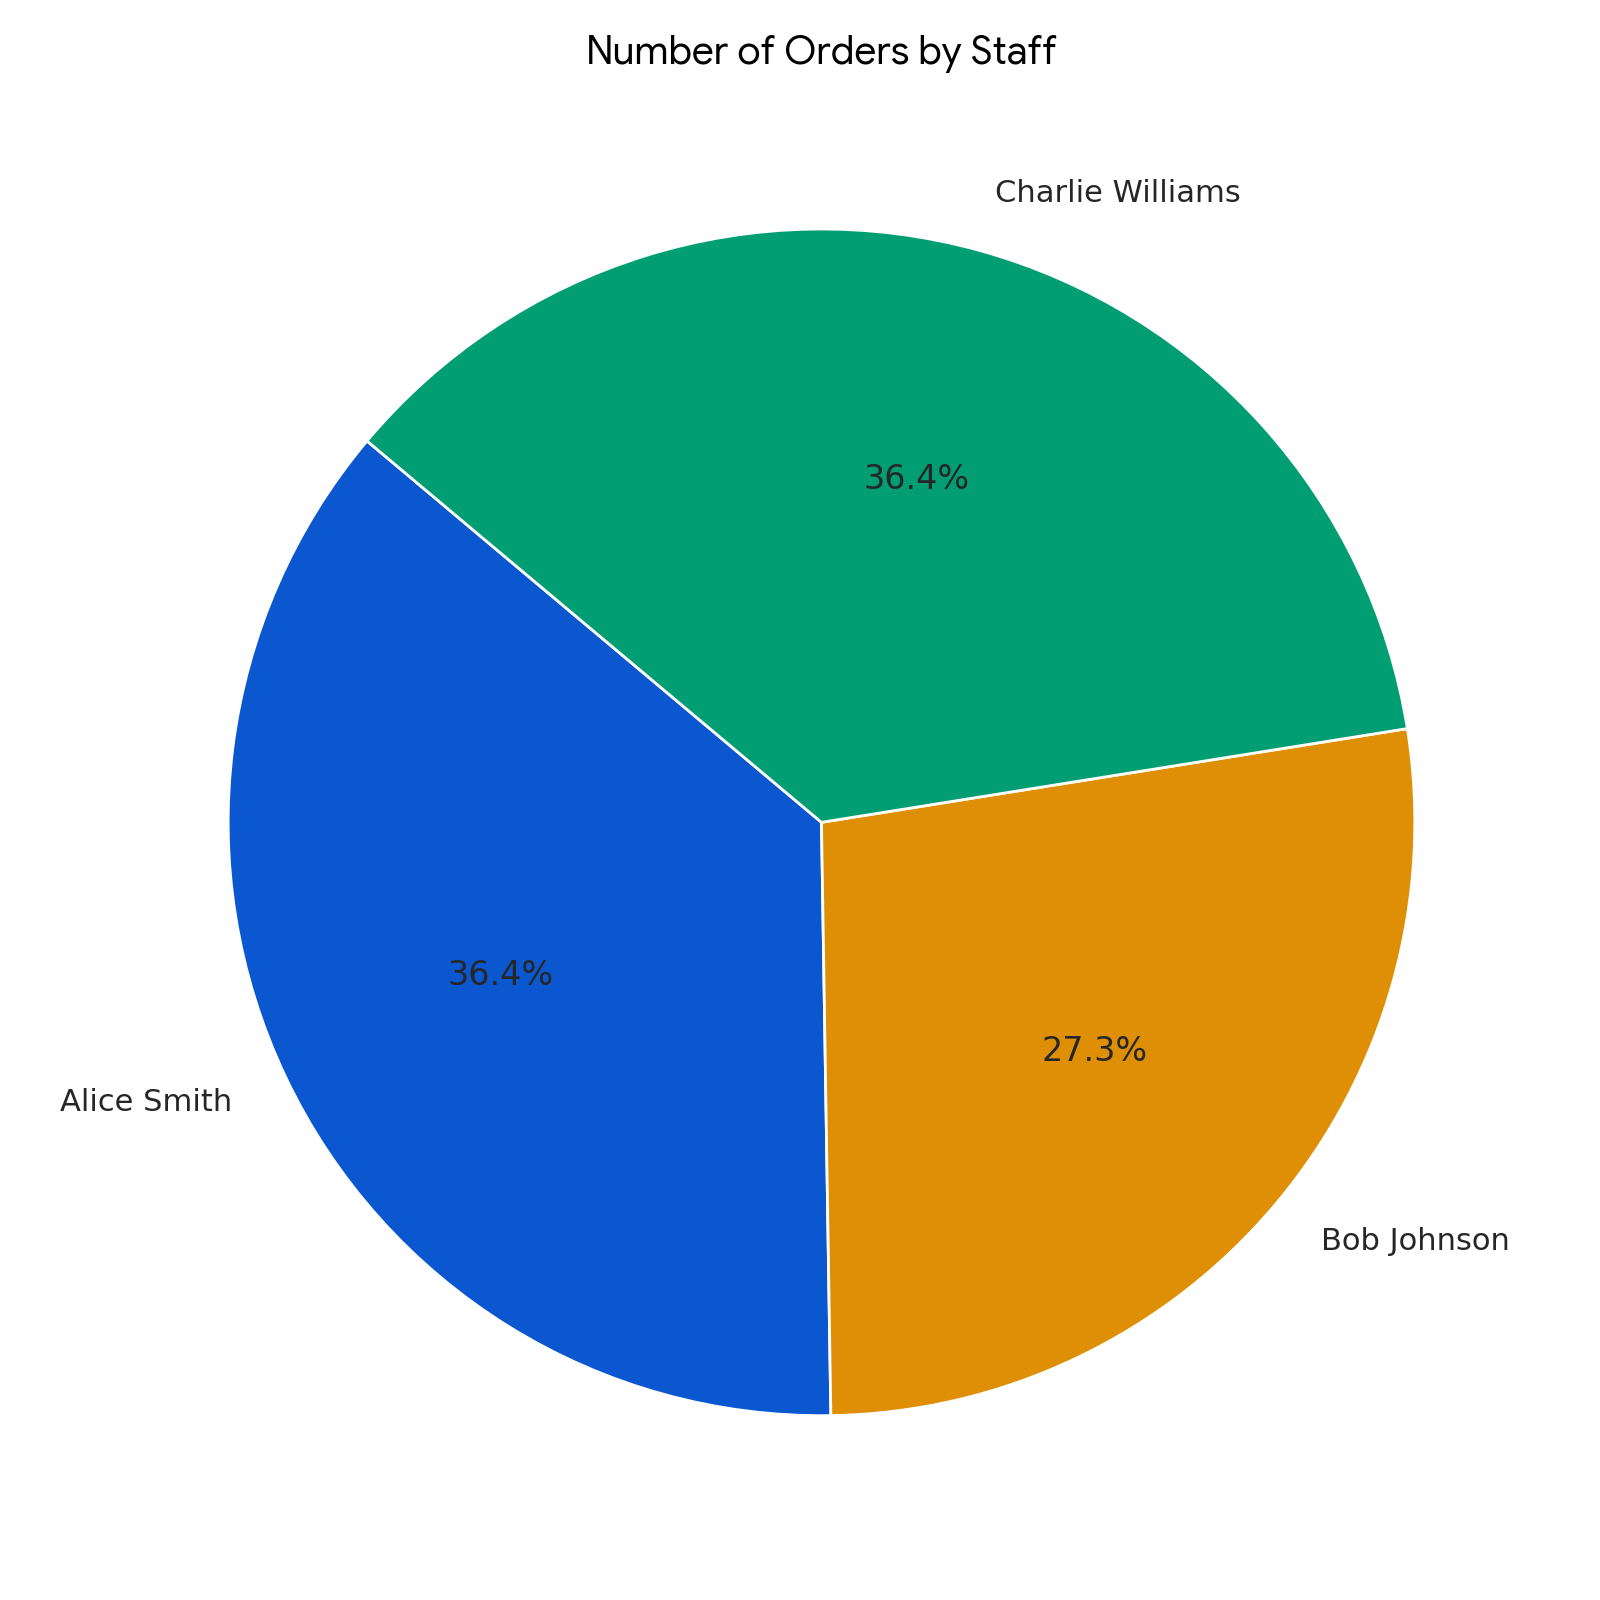

### Text

Okay, the pie chart visualizes the number of orders made by each staff member. Alice Smith and Charlie Williams both handled 36.4% of the orders each, while Bob Johnson handled 27.3% of the orders.



In [25]:
async with live_client.aio.live.connect(model=model, config=config) as session:

  message = "Can you figure out the number of orders that were made by each of the staff?"

  print(f"> {message}\n")
  await session.send(input=message, end_of_turn=True)
  await handle_response(session, tool_impl=execute_query)

  message = "Generate and run some code to plot this as a python seaborn pie chart"

  print(f"> {message}\n")
  await session.send(input=message, end_of_turn=True)
  await handle_response(session, tool_impl=execute_query)

In [33]:
import sqlite3
conn = sqlite3.connect("sample.db")
cursor = conn.cursor()
sql_query = "SELECT name FROM sqlite_master WHERE type='table';"
cursor.execute(sql_query)
print(cursor.fetchall())

[('products',), ('sqlite_sequence',), ('staff',), ('orders',)]


In [34]:
print(globals().keys())

dict_keys(['__name__', '__doc__', '__package__', '__loader__', '__spec__', '__builtin__', '__builtins__', '_ih', '_oh', '_dh', 'In', 'Out', 'get_ipython', 'exit', 'quit', '_', '__', '___', '_i', '_ii', '_iii', '_i1', '_exit_code', 'genai', 'types', '_1', '_i2', 'UserSecretsClient', '_i3', 'GOOGLE_API_KEY', '_i4', 'retry', 'is_retriable', '_i5', '_i6', '_i7', '_i8', '_i9', '_9', '_i10', 'sqlite3', 'db_file', 'db_conn', '_i11', '_i12', 'list_tables', '_12', '_i13', 'describe_table', '_13', '_i14', 'execute_query', '_14', '_i15', 'db_tools', 'instruction', 'client', 'chat', '_i16', 'resp', '_i17', 'response', '_i18', '_i19', 'textwrap', 'print_chat_turns', '_i20', 'pformat', 'display', 'Image', 'Markdown', 'handle_response', '_i21', '_i22', 'model', 'live_client', 'execute_query_tool_def', 'sys_int', 'config', 'session', 'message', '_i23', '_i24', '_i25', '_i26', 'sql_query', '_i27', '_i28', 'conn', 'cursor', '_i29', '_i30', '_i31', '_i32', '_i33', '_i34'])


In [36]:
# print(default_api.execute_query(sql="PRAGMA table_info(staff);"))
# print(default_api.execute_query(sql="PRAGMA table_info(orders);"))

import sqlite3

conn = sqlite3.connect("sample.db")
cursor = conn.cursor()

print("Staff Table:")
cursor.execute("PRAGMA table_info(staff);")
print(cursor.fetchall())

print("\nOrders Table:")
cursor.execute("PRAGMA table_info(orders);")
print(cursor.fetchall())

conn.close()

Staff Table:
[(0, 'staff_id', 'INTEGER', 0, None, 1), (1, 'first_name', 'VARCHAR(255)', 1, None, 0), (2, 'last_name', 'VARCHAR(255)', 1, None, 0)]

Orders Table:
[(0, 'order_id', 'INTEGER', 0, None, 1), (1, 'customer_name', 'VARCHAR(255)', 1, None, 0), (2, 'staff_id', 'INTEGER', 1, None, 0), (3, 'product_id', 'INTEGER', 1, None, 0)]


In [49]:
import sqlite3

conn = sqlite3.connect("sample.db")
cursor = conn.cursor()

sql_query = """
SELECT
    s.first_name,
    s.last_name,
    COUNT(o.order_id) AS number_of_orders
FROM
    staff s
JOIN
    orders o ON s.staff_id = o.staff_id
GROUP BY
    s.staff_id;
"""

cursor.execute(sql_query)
results = cursor.fetchall()

for row in results:
    print(f"{row[0]} {row[1]} {row[2]} - Orders: {row[2]}")

conn.close()

Alice Smith 2 - Orders: 2
Bob Johnson 1 - Orders: 1


Text(0, 0.5, 'Staff Member')

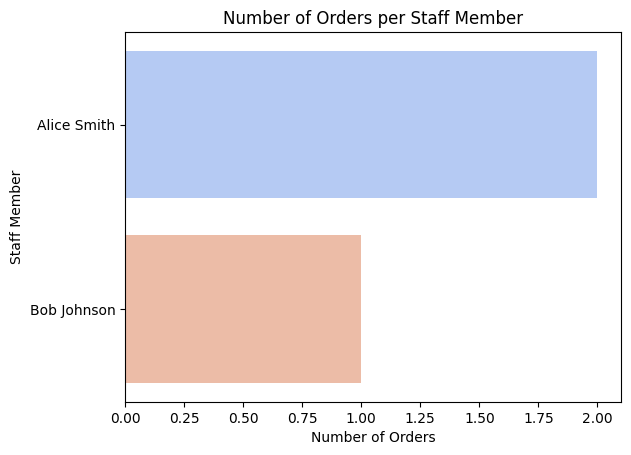

In [48]:
import sqlite3
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Step 1: Run the SQL query and get results
conn = sqlite3.connect("sample.db")
query = """
SELECT
    s.first_name || ' ' || s.last_name AS staff_name,
    COUNT(o.order_id) AS number_of_orders
FROM
    staff s
JOIN
    orders o ON s.staff_id = o.staff_id
GROUP BY
    s.staff_id;
"""
df = pd.read_sql_query(query, conn)
conn.close()

sns.barplot(x='number_of_orders', y='staff_name', data=df, palette='coolwarm')
plt.title('Number of Orders per Staff Member')
plt.xlabel('Number of Orders')
plt.ylabel('Staff Member')
